In [1]:
import os
import torch
import cv2
import matplotlib.pyplot as plt
import re
import numpy as np

In [2]:
data_path = "../data/"

data_channel_path = os.path.join(data_path, "data_channel")
rgb_channel_path = os.path.join(data_channel_path, "incoherent_RGBchannels")
rgb_channel_train_path = os.path.join(rgb_channel_path, "train_incoherent_RGBChannels")
rgb_channel_same_val_path = os.path.join(rgb_channel_path, "testRawData_incoherent_diffProtocol")

### incoherent_RGBchannels

In [3]:
pattern = "Seg(\d+)_defocus(\-?\d+)"

In [4]:
segment_dict = {}
for segment_name in os.listdir(rgb_channel_train_path):
    segment_path = os.path.join(rgb_channel_train_path, segment_name)
    seg_dict = {}
    for image_name in os.listdir(segment_path):
        image_path = os.path.join(segment_path, image_name)
        match = re.search(pattern, image_name)
        if match:
            seg_num, defocus = int(match.group(1)), int(match.group(2))
            
        if seg_num not in seg_dict:
            seg_dict[seg_num] = []
        seg_dict[seg_num].append((defocus, image_path))
        
    segment_dict[segment_name] = seg_dict

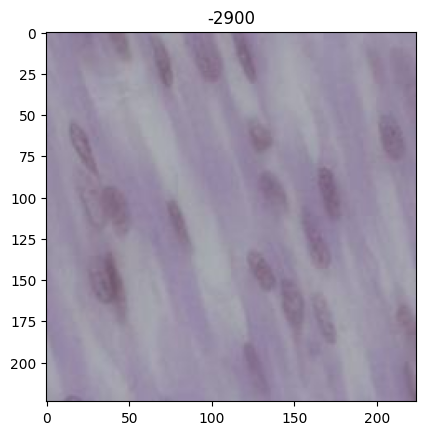

In [5]:
defocus, img_path = segment_dict["s93_l1"][2][np.random.randint(41)]
img = cv2.imread(img_path)
plt.title(defocus)
plt.imshow(img)

In [8]:
def get_fourier_channel(image: np.ndarray):
    img_numpy = image  # .transpose(1, 2, 0)
    img_gray = cv2.cvtColor(img_numpy, cv2.COLOR_RGB2GRAY)
    dft = cv2.dft(np.float32(img_gray), flags=cv2.DFT_COMPLEX_OUTPUT)

    dft_shift = np.fft.fftshift(dft)
    eps = 1e-9
    magnitude_spectrum = 20 * np.log(cv2.magnitude(
        dft_shift[..., 0],
        dft_shift[..., 1]) + eps
    )
    # magnitude_spectrum_tensor = torch.tensor(magnitude_spectrum)
    return magnitude_spectrum

In [11]:
magnitude_spectrum = get_fourier_channel(img)

In [1]:
# img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# dft = cv2.dft(np.float32(img_gray), flags = cv2.DFT_COMPLEX_OUTPUT)

# dft_shift = np.fft.fftshift(dft)
# magnitude_spectrum = 20*np.log(cv2.magnitude(
#   dft_shift[:,:,0],
#   dft_shift[:,:,1])
# )

In [23]:
magnitude_spectrum.shape

(224, 224)

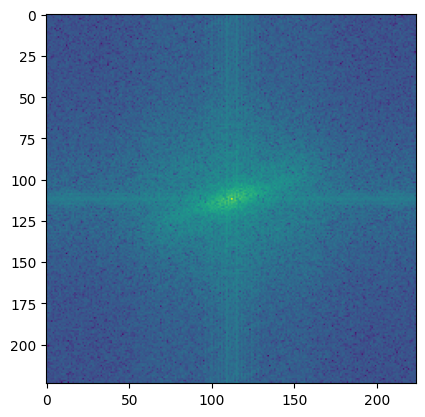

In [12]:
plt.imshow(magnitude_spectrum)

In [7]:
# sorted(segment_dict["s93_l1"][2])

In [9]:
from hydra import initialize, initialize_config_module, initialize_config_dir, compose
from hydra.utils import instantiate


with initialize(version_base=None, config_path="../configs/"):
    config = compose(overrides=["+db=mysql", "+dataset=rgb_dataset"])
    print(config)

{'dataset': {'data_path': '/home/dkrivenkov/program/autofocusing/data/data_domain_1/dualLED_3domains/train_dualLED_3domains', 'same_data_path': '/home/dkrivenkov/program/autofocusing/data/data_domain_1/dualLED_3domains/testRawData_dualLED_sameProtocol', 'diff_data_path': '/home/dkrivenkov/program/autofocusing/data/data_domain_1/dualLED_3domains/testRawData_dualLED_diffProtocol', 'train_ratio': 0.8, 'train_dataset': {'_target_': 'dataset.focusdataset.FocusingDataset', 'pattern': 'Seg(\\d+)_defocus(\\-?\\d+)', 'images_data': '???'}, 'val_dataset': {'_target_': 'dataset.focusdataset.FocusingDataset', 'pattern': 'Seg(\\d+)_defocus(\\-?\\d+)', 'images_data': '???'}, 'test_dataset': {'_target_': 'dataset.focusdataset.FocusingDataset', 'pattern': 'defocus(\\-?\\d+)', 'images_data': '???'}, 'train_dataloader': {'_target_': 'torch.utils.data.DataLoader', 'batch_size': 128, 'drop_last': True, 'num_workers': 10}, 'val_dataloader': {'_target_': 'torch.utils.data.DataLoader', 'batch_size': 128, 'nu

In [10]:
import sys
sys.path.append("..")

from dataset.data_module import DataModule
from dataset.utils import split_dataset

In [11]:
datamodule = DataModule(config)

In [20]:
datamodule.prepare_data()
datamodule.setup("train")

In [27]:
# dataloder_test = datamodule.test_dataloader()
# for loader_name, loader in dataloder_test.items():
#     loader
# # x, y = next(iter(dataloder_test))

AttributeError: 'CombinedLoader' object has no attribute 'items'

In [26]:
dataloder_test

'diff_protocol'

In [13]:
images_train_rgb, images_val_rgb = split_dataset(datamodule.rgb_data)

In [14]:
len(images_train_rgb), len(images_val_rgb)

(100942, 25543)

In [15]:
img = cv2.imread(str(datamodule.same_data[-1]))

In [16]:
img.shape

(2048, 2448, 3)

In [17]:
import torch.nn as nn
from torchvision.models import vit_b_32, ViT_B_32_Weights
model = vit_b_32(weights=ViT_B_32_Weights.DEFAULT, progress=True)

In [18]:
import pyiqa
iqa_metric = pyiqa.create_metric('niqe', test_y_channel=True, color_space='rgb')